In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt


In [2]:
def generate_gaussian_data(n_samples=1000, mean=[0, 0], cov=[[1, 0],
                                                              [0, 1]]):
    data = np.random.multivariate_normal(mean, cov, n_samples)
    return torch.tensor(data, dtype=torch.float32)


In [3]:
data = generate_gaussian_data()
# data = torch.vstack((generate_gaussian_data(), generate_gaussian_data(cov=[[1,-1],[-1,1]])))

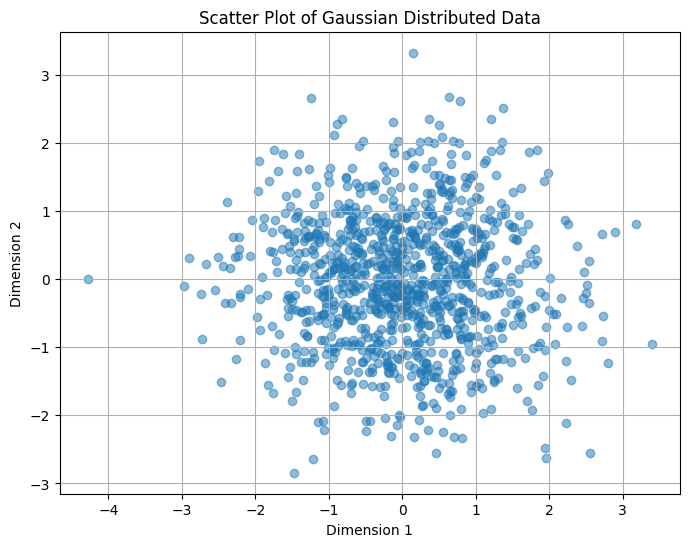

In [4]:
def plot_data(data):
    """Plot 2D data using a scatter plot."""
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
    plt.title('Scatter Plot of Gaussian Distributed Data')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()

plot_data(data)


In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc21 = nn.Linear(50, latent_dim)  # For mu
        self.fc22 = nn.Linear(50, latent_dim)  # For log variance

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 50)
        self.fc4 = nn.Linear(50, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def encode_latent(self, x):
        with torch.no_grad():
            mu, _ = self.encode(x)
            return mu

In [6]:
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction="sum")
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KL

In [7]:
model = VAE()
optimizer = Adam(model.parameters(), lr=1e-3)
data_loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)


In [8]:
for epoch in range(100):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(data_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(data_loader.dataset)}] Loss: {loss.item() / len(data):.6f}"
            )


/home/titi/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Epoch: 0 [0/1000] Loss: 2.588173
Train Epoch: 0 [640/1000] Loss: 2.053942
Train Epoch: 1 [0/1000] Loss: 1.726837
Train Epoch: 1 [640/1000] Loss: 2.370417
Train Epoch: 2 [0/1000] Loss: 1.654458
Train Epoch: 2 [640/1000] Loss: 2.412165
Train Epoch: 3 [0/1000] Loss: 2.042253
Train Epoch: 3 [640/1000] Loss: 2.188174
Train Epoch: 4 [0/1000] Loss: 1.893788
Train Epoch: 4 [640/1000] Loss: 1.677759
Train Epoch: 5 [0/1000] Loss: 1.715098
Train Epoch: 5 [640/1000] Loss: 1.326536
Train Epoch: 6 [0/1000] Loss: 2.090240
Train Epoch: 6 [640/1000] Loss: 1.994348
Train Epoch: 7 [0/1000] Loss: 1.937573
Train Epoch: 7 [640/1000] Loss: 2.077862
Train Epoch: 8 [0/1000] Loss: 1.420586
Train Epoch: 8 [640/1000] Loss: 1.504661
Train Epoch: 9 [0/1000] Loss: 1.754127
Train Epoch: 9 [640/1000] Loss: 1.610392
Train Epoch: 10 [0/1000] Loss: 1.550664
Train Epoch: 10 [640/1000] Loss: 1.679370
Train Epoch: 11 [0/1000] Loss: 2.191572
Train Epoch: 11 [640/1000] Loss: 1.771154
Train Epoch: 12 [0/1000] Loss: 1.650

In [9]:
latent_variables = []
for data in data_loader:
    mu = model.encode_latent(data)
    latent_variables.append(mu)
latent_variables = torch.cat(latent_variables, 0)

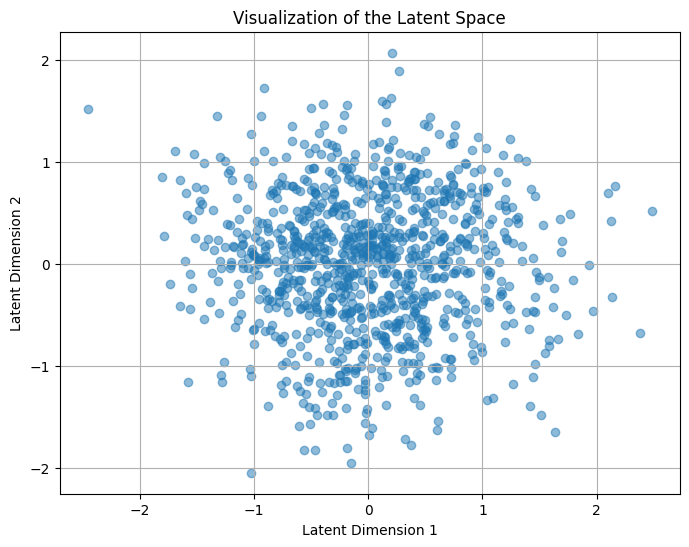

In [10]:

x, y = latent_variables[:, 0].numpy(), latent_variables[:, 1].numpy()

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Visualization of the Latent Space')
plt.grid(True)
plt.show()

In [11]:
def sample_from_vae(model, n_samples=100, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Sample from a standard normal distribution
        z = torch.randn(n_samples, model.latent_dim).to(device) 
        # Decode the sample
        sampled_data = model.decode(z)
    return sampled_data


In [12]:
# Example of generating 10 new data points
n_samples = 500
generated_data = sample_from_vae(model, n_samples=n_samples, device='cpu')

# Convert to numpy for visualization or further processing, if necessary
generated_data = generated_data.cpu().numpy()


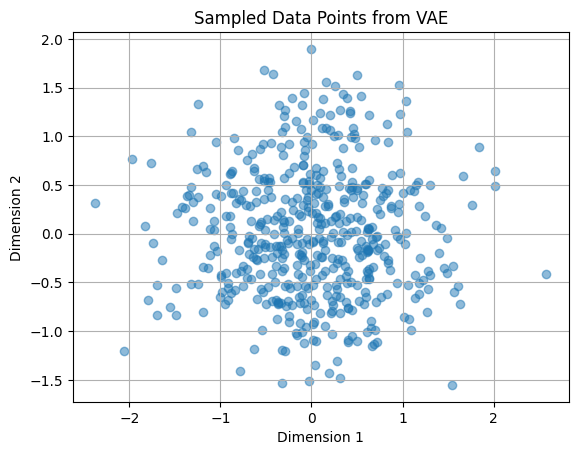

In [13]:
plt.scatter(generated_data[:, 0], generated_data[:, 1], alpha=0.5)
plt.title("Sampled Data Points from VAE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()
